# Magnification factor of $\beta$-VAE toy example
[Yusuke Hayashi](https://github.com/hayashiyus)<br/>
April 30, 2024 <br/>

## Variational inference
Given samples $x$ from an unobserved data density $q(x)$, we are interested in building a latent-variable generative model $p_{\varphi}(x, z)$ such that $p(x)$ is close to $q(x)$. This is a difficult problem as evaluating the density under the model, $p(x)$ requires evaluating an intractable integral over the unobserved latent variable $z$: $p_{\varphi}(x)=\int \mathrm{d}z \;p_{\varphi}(x, z)$.
$$
\begin{gathered}
q_\phi(x, z) = q(x) q_\phi(z \mid x) \\
p_{\varphi}(x, z) = p(z) p_{\varphi}(x \mid z)
\end{gathered}
$$
The variational principle bypasses this problem by optimizing a lower bound on the log-likelihood of the data. In this case, the objective $\mathcal{L}_{\mathrm{VAE-ELBO}}$:
$$
\begin{aligned}
\mathbb{E}_{q(x)}\left[\log p_{\varphi}(x)\right] & =\mathbb{E}_{q(x)}\left[\log \int p_{\varphi}(x, \psi) d \psi\right] \\
& =\mathbb{E}_{q(x)}\left[\log \int q_\phi(\psi \mid x) \frac{p_{\varphi}(x, \psi)}{q_\phi(\psi \mid x)} d \psi\right] \\
& \geq \mathbb{E}_{q(x)}\left[\int q_\phi(\psi \mid x) \log \frac{p_{\varphi}(x, \psi)}{q_\phi(\psi \mid x)} d \psi\right] \\
& =\mathbb{E}_{q_\phi(x, \psi)}\left[\log p_{\varphi}(x \mid \psi)\right]-\mathbb{E}_{q(x)}\left[D_{\mathrm{KL}}\left(q_\phi(\psi \mid x) \| p(\psi)\right)\right] := \mathcal{L}_{\mathrm{VAE-ELBO}}
\end{aligned}
$$
The objective of $\beta$-VAE $\mathcal{L}_{\beta-\mathrm{VAE}}$ is given as a slight modification of the ELBO of VAE:
$$
\mathcal{L}_{\beta-\mathrm{VAE}} := \mathbb{E}_{q_\phi(x, z)}\left[\log p_{\varphi}(x \mid z)\right]-\frac{1}{\beta} \mathbb{E}_{q(x)}\left[D_{\mathrm{KL}}\left(q_\phi(z \mid x) \| p(z)\right)\right]
$$
The objective of $\beta$-VAE $\mathcal{L}_{\beta-\mathrm{VAE}}$ can be derived according to the variational principle by modifying the respective encoder and decoder models as follows:
$$
\begin{aligned}
& q_{\beta, \phi}(x, z)=\frac{q^\beta(x) q_\phi(z \mid x)}{Z_q(\beta)} . \\
& p_{\beta, \varphi}(x, z)=\frac{p(z) p_{\varphi}^\beta(x \mid z)}{Z_p(\beta)} .
\end{aligned}
$$
$$
\begin{aligned}
\mathcal{L}_{\mathrm{Neq-VAE}} &:= \mathbb{E}_{q_{\beta, \phi}(x, z)}\left[\log p_{\varphi}(x \mid z)\right]-\frac{1}{\beta} \mathbb{E}_{q^\beta(x)}\left[D_{\mathrm{KL}}\left(q_\phi(z \mid x) \| p(z)\right)\right]
\end{aligned}
$$
$$
\begin{aligned}
-\frac{1}{\beta} D_{\mathrm{KL}}\left(q_{\beta, \phi}(x, z) \| p_{\beta, \varphi}(x, z)\right) & =-\frac{1}{\beta} \mathbb{E}_{q_{\beta, \phi}(x, z)}\left[\log \frac{q_{\beta, \phi}(x, z)}{p_{\beta, \varphi}(x, z)}\right] \\
& =-\frac{1}{\beta} \mathbb{E}_{q_{\beta, \phi}(x, z)}\left[\log \frac{Z_p(\beta) q^\beta(x) q_\phi(z \mid x)}{Z_q(\beta) p(z) p_{\varphi}^\beta(x \mid z)}\right] \\
& =\frac{1}{\beta}\left(-\log \frac{Z_p(\beta)}{Z_q(\beta)}+H_{q_\phi^\beta}(x)\right)+\mathcal{L}_{\text{Neq-VAE}} \\
& \geq \frac{1}{\beta}\left(-\log \frac{Z_p(\beta)}{Z_q(\beta)}+H_{q_\phi^\beta}(x)\right)+\mathcal{L}_{\beta-\mathrm{VAE}} .
\end{aligned}
$$

This lower bound depends on an additional distribution, $q(z|x)$ which is known as the _variational distribution_ and acts as an approximation to the true posterior $p(z|x)$. 
To evaluate and learn using the variational lower bound, we need to be able to draw samples from the _variational distribution_ and to evaluate the density of a sample from the _variational distribution_. This typically restricts the family of variational distributions to those with known or tractable densities (e.g. factorial Gaussian, normalizing flows).

Send questions/comments/bugs to [@hayashiyus](https://twitter.com/hayashiyus).

## Create dataset of one-hot vectors

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Bernoulli
from torch.utils.data import DataLoader, TensorDataset
from sklearn import datasets
import sklearn.preprocessing as sp
import sklearn.model_selection as sm
import matplotlib
import mplcyberpunk
import matplotlib.cm as cm
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from mpl_toolkits.mplot3d import axes3d

plt.style.use("cyberpunk")

# Load training datasets
MNIST = datasets.load_digits()
X = MNIST.data  # X: images
X = X / 16  # Normalize pixel values
yl = MNIST.target  # yl: labels
D, n = X.shape

n_im_row, n_im_col = 5, 15
n_im = n_im_row * n_im_col
d = np.arange(D)
d_choice = np.random.choice(np.arange(D), n_im, replace=False)

n_px_row = np.floor(np.sqrt(n)).astype('int')
n_px_col = (n / n_px_row).astype('int')

# Split the dataset into train and test datasets
X_train, X_test, yl_train, yl_test = sm.train_test_split(X, yl, train_size=1/2, test_size=1/2)

X_test = X_test[:-1]
yl_test = yl_test[:-1]

# create dataset of one-hot vectors
# class size
C = 10                      
# .A means 'change the data type from a matrix to an array'
enc = sp.OneHotEncoder()
Y_train = enc.fit_transform(yl_train.reshape(-1, 1)).A
Y_test = enc.fit_transform(yl_test.reshape(-1, 1)).A

print('訓練データ数：D_train =', len(Y_train))
print('テストデータ数：D_test =', len(Y_test))

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
Y_test = torch.tensor(Y_test, dtype=torch.long)

訓練データ数：D_train = 898
テストデータ数：D_test = 898


## Setup

In [2]:
# Constants
n_epoch = 100000 + 1
batch_size = X_train.shape[0]
latent_dim = 2  # Assuming latent_dim is 2 for this example
n_layer = 4  # Assuming n_layer is 4 for this example
n_unit = 256  # Assuming n_unit is 256 for this example
output_dim = Y_train.shape[1]  # Assuming output_dim is the number of classes

# Data
x = torch.tensor(X_train, dtype=torch.float32)
y = torch.tensor(Y_train, dtype=torch.float32)

# データセットの準備
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Encoder network
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc_layers = nn.Sequential(*[nn.Linear(hidden_dim if i > 0 else input_dim, hidden_dim) for i in range(n_layer)])
        self.loc = nn.Linear(hidden_dim, latent_dim)
        self.scale = nn.Linear(hidden_dim, latent_dim)
        self.softplus = nn.Softplus()
    
    def forward(self, x):
        enc = self.fc_layers(x)
        loc = self.loc(enc)
        scale = 1e-6 + (1 - 2e-6) * self.softplus(self.scale(enc))
        return loc, scale

# Decoder network
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_layers = nn.Sequential(*[nn.Linear(hidden_dim if i > 0 else latent_dim, hidden_dim) for i in range(n_layer)])
        self.dec = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, z):
        dec = self.fc_layers(z)
        dec = 1e-6 + (1 - 2e-6) * self.sigmoid(self.dec(dec))
        return dec

# Instantiate networks
encoder = Encoder(input_dim=x.shape[1], hidden_dim=n_unit, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=n_unit, output_dim=output_dim)
encoder_params = dict(encoder.named_parameters())
decoder_params = dict(decoder.named_parameters())

/var/folders/fw/ch0md4dj6x353_sr7k4k_f3r0000gq/T/ipykernel_95221/2164076786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X_train, dtype=torch.float32)
/var/folders/fw/ch0md4dj6x353_sr7k4k_f3r0000gq/T/ipykernel_95221/2164076786.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(Y_train, dtype=torch.float32)
/var/folders/fw/ch0md4dj6x353_sr7k4k_f3r0000gq/T/ipykernel_95221/2164076786.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tens

In [3]:
def compute_jacobian(model, params, input):
    func = torch.func.functional_call(model, params, input)
    output_dim = func.shape[1]
    #J = [torch.autograd.grad(outputs=func[:, i], inputs=input, grad_outputs=torch.ones_like(func[:, i]), allow_unused=True, retain_graph=True, create_graph=True)[0] for i in range(output_dim)]
    J = [torch.autograd.grad(outputs=func[:, i], inputs=input, grad_outputs=func[:, i], allow_unused=True, retain_graph=True, create_graph=False)[0] for i in range(output_dim)]
    J = torch.stack(J, dim=1)  # batch x output x latent
    return J

def compute_logprobs(model, params, input, cyclical_beta, j):
    func = torch.func.functional_call(model, params, input)
    log_probs = Bernoulli(probs=func.pow_(cyclical_beta[j])).log_prob(y)
    output_dim = func.shape[1]
    #J = [torch.autograd.grad(outputs=log_probs[:, i], inputs=input, grad_outputs=torch.ones_like(log_probs[:, i]), allow_unused=True, retain_graph=True, create_graph=True)[0] for i in range(output_dim)]
    J = [torch.autograd.grad(outputs=log_probs[:, i], inputs=input, grad_outputs=log_probs[:, i], allow_unused=True, retain_graph=True, create_graph=False)[0] for i in range(output_dim)]
    J = torch.stack(J, dim=1)  # batch x output x latent
    return J

def compute_magnification_factor(J):
    """
    creates the metric tensor (J^T J and J being the jacobian of the decoder), 
    which can be evaluated at any point in Z
    and
    the magnification factor
    """
    G = torch.matmul(J.permute(0, 2, 1), J)  # J^T \cdot J
    # magnification factor
    mf = torch.sqrt(torch.det(G))
    return mf

def compute_fisher_information_factor(J):
    """
    Computes the Fisher Information Factor using the Jacobian matrix.
    
    Args:
    - jacobian (torch.Tensor): The Jacobian matrix. Shape: [batch_size, output_dim, input_dim].
    
    Returns:
    - fif (torch.Tensor): The Fisher Information Factor. Shape: [batch_size].
    """
    G = torch.matmul(J.permute(0, 2, 1), J)  # J^T \cdot J
    # fisher information factor
    fif = torch.diagonal(G, dim1=1, dim2=2).sum(dim=1)
    return fif

def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    tiled_x = x.view(x_size, 1, dim).expand(x_size, y_size, dim)
    tiled_y = y.view(1, y_size, dim).expand(x_size, y_size, dim)
    return torch.exp(-torch.mean((tiled_x - tiled_y) ** 2, dim=2) / dim)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)

  0%|          | 0/100001 [00:00<?, ?it/s]

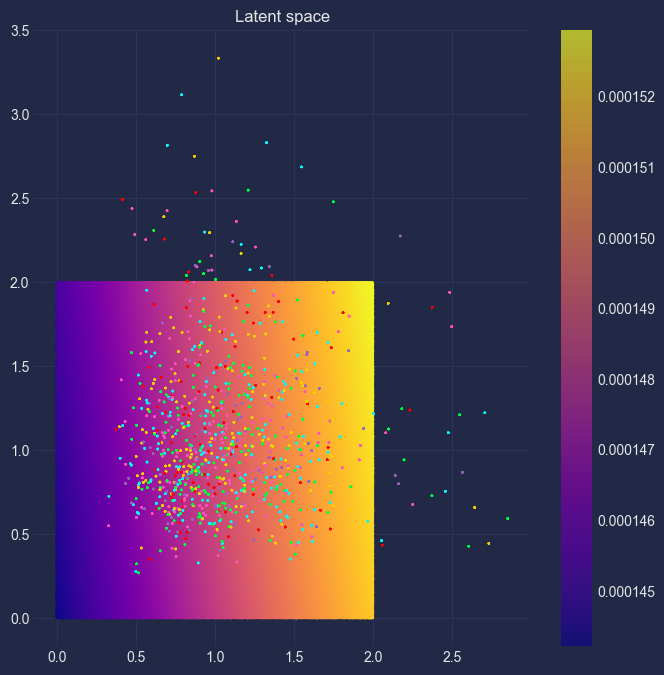

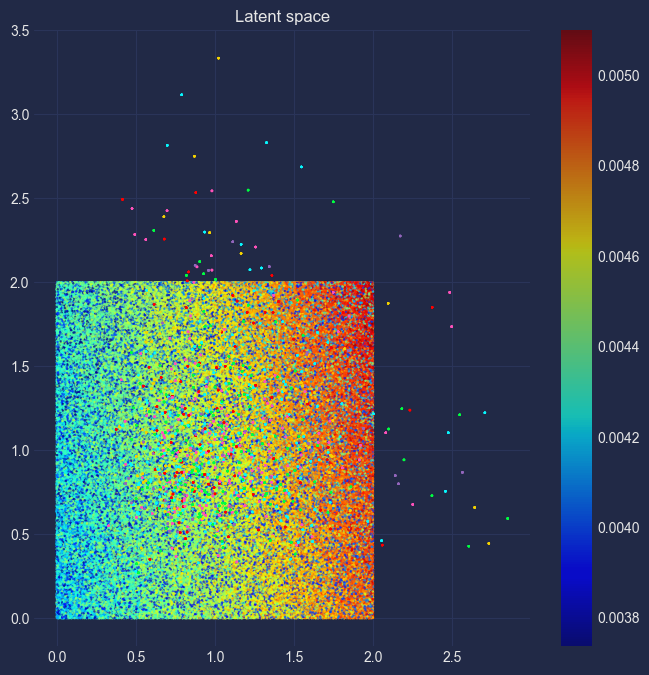

  0%|          | 12/100001 [00:19<33:13:00,  1.20s/it]

    0:(beta)=(    0.8000)


  1%|          | 1023/100001 [00:29<13:47, 119.62it/s]

 1000:(beta)=(    0.6082)


  2%|▏         | 2022/100001 [00:37<13:42, 119.08it/s]

 2000:(beta)=(    0.6912)


  3%|▎         | 3020/100001 [00:46<13:16, 121.72it/s]

 3000:(beta)=(    0.9301)


  4%|▍         | 4013/100001 [00:54<13:18, 120.21it/s]

 4000:(beta)=(    0.9826)


  5%|▌         | 5017/100001 [01:03<13:19, 118.86it/s]

 5000:(beta)=(    0.7735)


  6%|▌         | 6018/100001 [01:11<13:28, 116.19it/s]

 6000:(beta)=(    0.6024)


  7%|▋         | 7013/100001 [01:20<13:24, 115.52it/s]

 7000:(beta)=(    0.7144)


  8%|▊         | 8018/100001 [01:28<12:35, 121.69it/s]

 8000:(beta)=(    0.9491)


  9%|▉         | 9016/100001 [01:37<13:04, 116.05it/s]

 9000:(beta)=(    0.9701)


 10%|▉         | 9990/100001 [02:00<12:34, 119.23it/s]

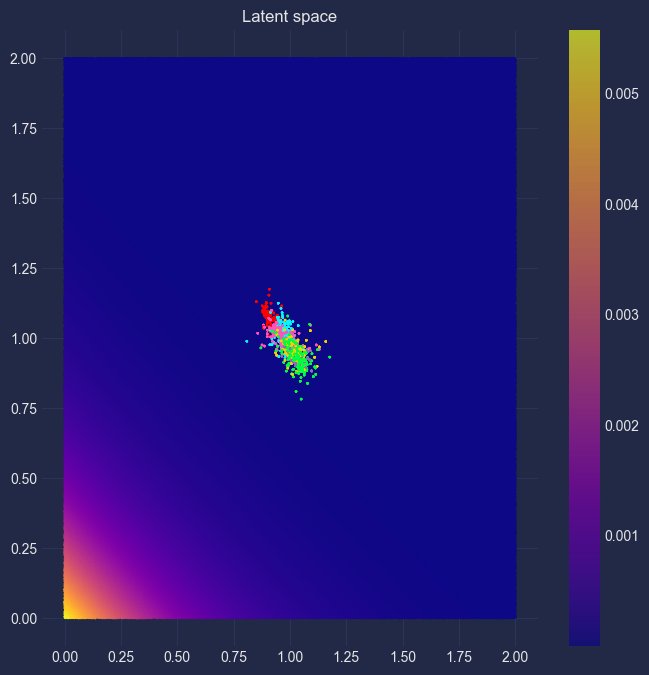

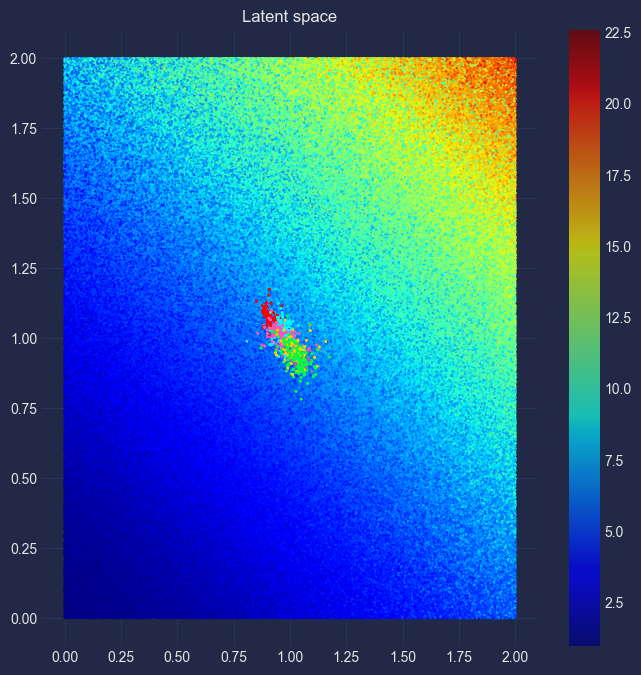

 10%|█         | 10014/100001 [02:06<8:57:02,  2.79it/s] 

10000:(beta)=(    0.7474)


 11%|█         | 11017/100001 [02:14<11:52, 124.92it/s] 

11000:(beta)=(    0.6000)


 12%|█▏        | 12023/100001 [02:22<11:27, 127.93it/s]

12000:(beta)=(    0.7392)


 13%|█▎        | 13013/100001 [02:30<11:57, 121.21it/s]

13000:(beta)=(    0.9654)


 14%|█▍        | 14014/100001 [02:38<11:09, 128.42it/s]

14000:(beta)=(    0.9547)


 15%|█▌        | 15018/100001 [02:46<11:20, 124.84it/s]

15000:(beta)=(    0.7223)


 16%|█▌        | 16024/100001 [02:54<10:51, 128.85it/s]

16000:(beta)=(    0.6012)


 17%|█▋        | 17017/100001 [03:02<10:50, 127.57it/s]

17000:(beta)=(    0.7650)


 18%|█▊        | 18022/100001 [03:10<11:15, 121.39it/s]

18000:(beta)=(    0.9789)


 19%|█▉        | 19025/100001 [03:18<10:41, 126.23it/s]

19000:(beta)=(    0.9365)


 20%|█▉        | 19995/100001 [03:40<10:42, 124.48it/s]

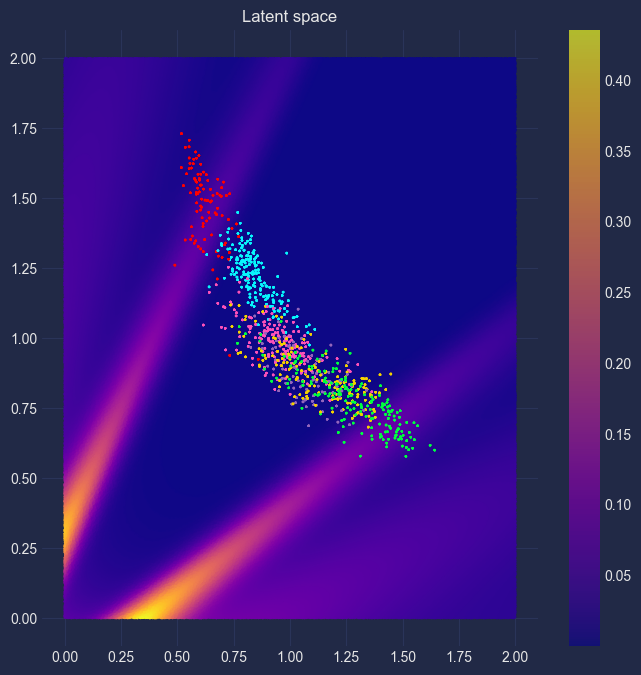

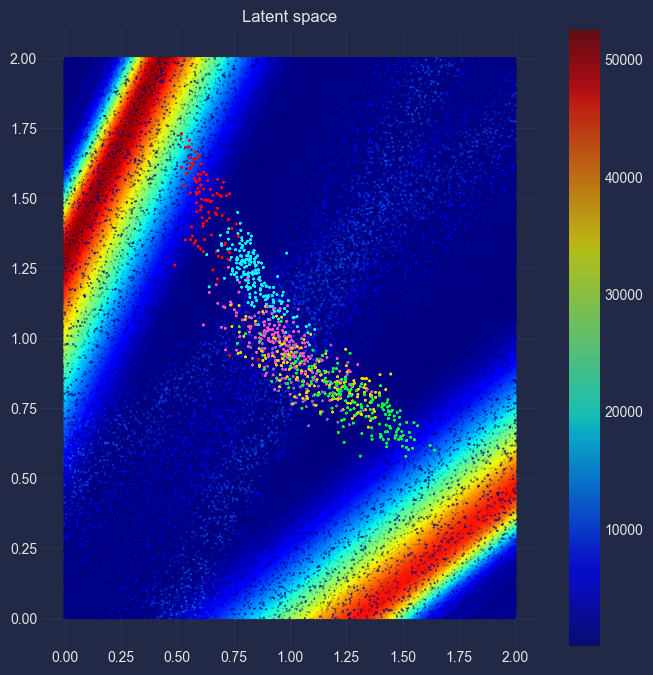

 20%|██        | 20014/100001 [03:45<8:06:20,  2.74it/s] 

20000:(beta)=(    0.6986)


 21%|██        | 21015/100001 [03:53<10:00, 131.61it/s] 

21000:(beta)=(    0.6059)


 22%|██▏       | 22014/100001 [04:01<09:49, 132.19it/s]

22000:(beta)=(    0.7914)


 23%|██▎       | 23017/100001 [04:08<09:55, 129.32it/s]

23000:(beta)=(    0.9892)


 24%|██▍       | 24025/100001 [04:16<10:17, 123.11it/s]

24000:(beta)=(    0.9159)


 25%|██▌       | 25019/100001 [04:24<09:34, 130.52it/s]

25000:(beta)=(    0.6766)


 26%|██▌       | 26020/100001 [04:32<09:37, 128.03it/s]

26000:(beta)=(    0.6141)


 27%|██▋       | 27014/100001 [04:40<09:20, 130.21it/s]

27000:(beta)=(    0.8179)


 28%|██▊       | 28018/100001 [04:48<09:14, 129.72it/s]

28000:(beta)=(    0.9961)


 29%|██▉       | 29016/100001 [04:55<09:18, 127.21it/s]

29000:(beta)=(    0.8933)


 30%|██▉       | 29994/100001 [05:03<08:57, 130.14it/s]

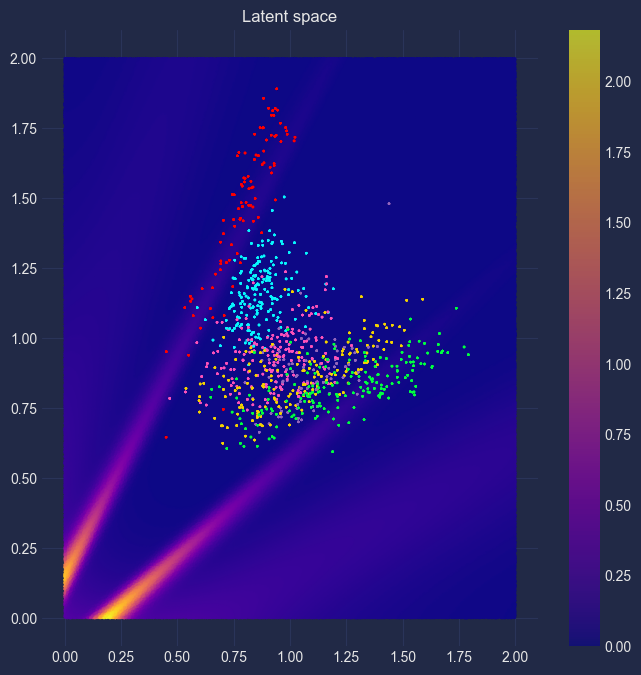

 30%|██▉       | 29994/100001 [05:20<08:57, 130.14it/s]

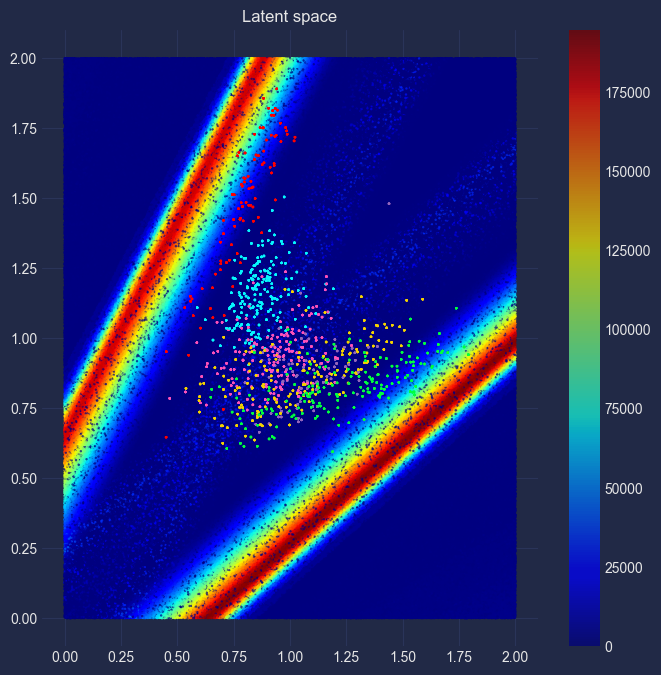

 30%|███       | 30014/100001 [05:22<6:26:48,  3.02it/s]

30000:(beta)=(    0.6568)


 31%|███       | 31018/100001 [05:29<08:49, 130.19it/s] 

31000:(beta)=(    0.6255)


 32%|███▏      | 32025/100001 [05:37<08:44, 129.69it/s]

32000:(beta)=(    0.8442)


 33%|███▎      | 33023/100001 [05:45<08:29, 131.49it/s]

33000:(beta)=(    0.9996)


 34%|███▍      | 34025/100001 [05:53<08:33, 128.37it/s]

34000:(beta)=(    0.8690)


 35%|███▌      | 35027/100001 [06:01<08:25, 128.48it/s]

35000:(beta)=(    0.6396)


 36%|███▌      | 36019/100001 [06:08<08:29, 125.61it/s]

36000:(beta)=(    0.6400)


 37%|███▋      | 37025/100001 [06:16<08:10, 128.37it/s]

37000:(beta)=(    0.8697)


 38%|███▊      | 38020/100001 [06:24<08:10, 126.38it/s]

38000:(beta)=(    0.9995)


 39%|███▉      | 39016/100001 [06:32<07:43, 131.51it/s]

39000:(beta)=(    0.8435)


 40%|███▉      | 40000/100001 [06:50<07:50, 127.49it/s]

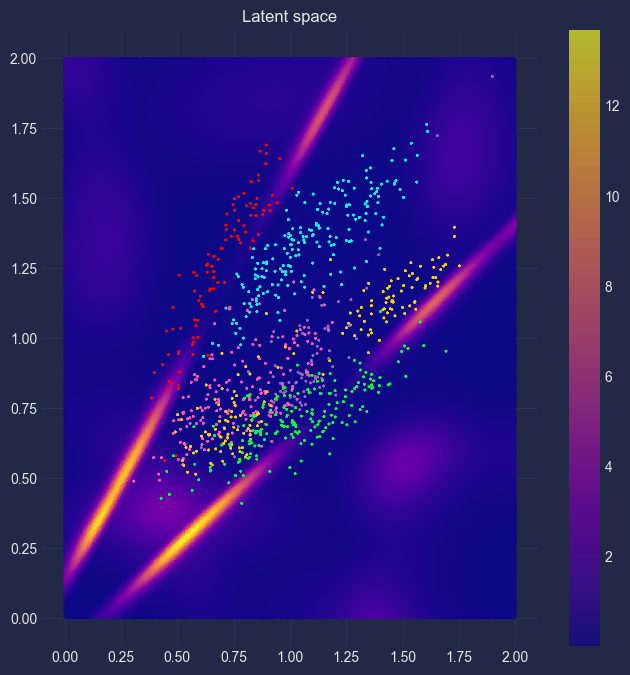

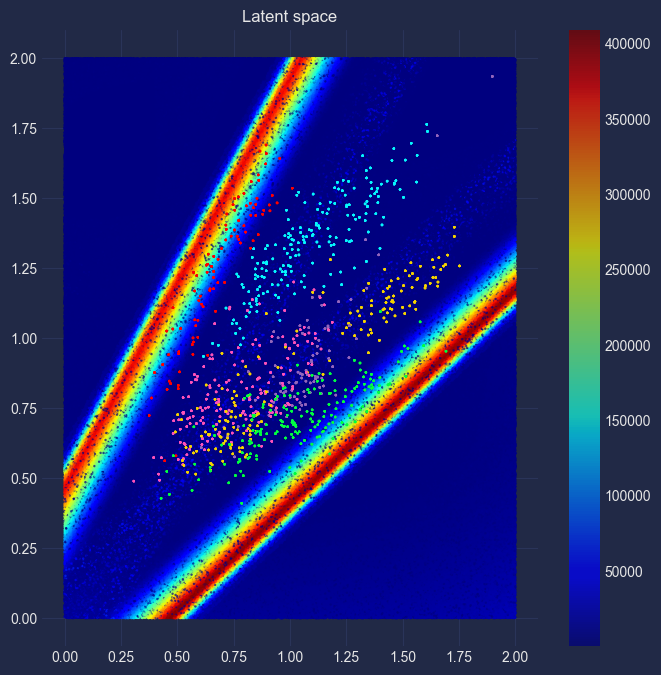

 40%|████      | 40014/100001 [06:59<6:32:40,  2.55it/s] 

40000:(beta)=(    0.6251)


 41%|████      | 41022/100001 [07:07<07:34, 129.77it/s] 

41000:(beta)=(    0.6573)


 42%|████▏     | 42020/100001 [07:15<07:21, 131.41it/s]

42000:(beta)=(    0.8939)


 43%|████▎     | 43021/100001 [07:22<07:20, 129.28it/s]

43000:(beta)=(    0.9960)


 44%|████▍     | 44025/100001 [07:30<07:13, 129.06it/s]

44000:(beta)=(    0.8172)


 45%|████▌     | 45021/100001 [07:38<07:09, 128.13it/s]

45000:(beta)=(    0.6138)


 46%|████▌     | 46026/100001 [07:46<06:54, 130.11it/s]

46000:(beta)=(    0.6771)


 47%|████▋     | 47016/100001 [07:53<06:45, 130.77it/s]

47000:(beta)=(    0.9165)


 48%|████▊     | 48015/100001 [08:01<06:58, 124.23it/s]

48000:(beta)=(    0.9889)


 49%|████▉     | 49023/100001 [08:09<06:34, 129.34it/s]

49000:(beta)=(    0.7907)


 50%|████▉     | 49997/100001 [08:30<06:26, 129.27it/s]

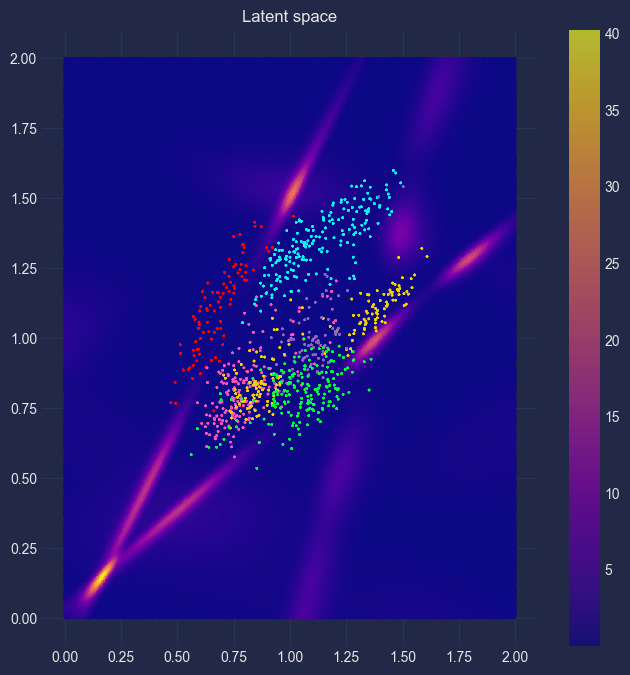

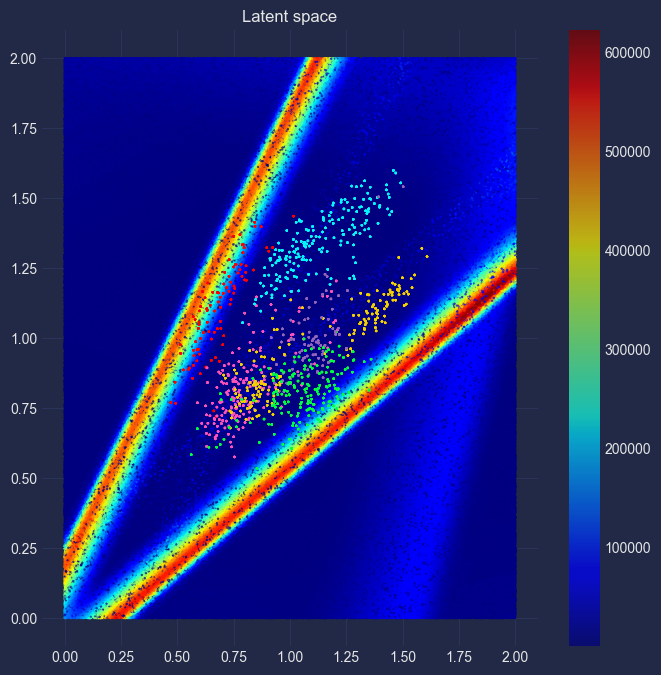

 50%|█████     | 50013/100001 [08:35<5:00:41,  2.77it/s]

50000:(beta)=(    0.6058)


 51%|█████     | 51021/100001 [08:44<07:20, 111.31it/s] 

51000:(beta)=(    0.6992)


 52%|█████▏    | 52018/100001 [08:53<07:18, 109.46it/s]

52000:(beta)=(    0.9370)


 53%|█████▎    | 53021/100001 [09:02<06:59, 111.96it/s]

53000:(beta)=(    0.9786)


 54%|█████▍    | 54011/100001 [09:11<07:12, 106.24it/s]

54000:(beta)=(    0.7643)


 55%|█████▌    | 55015/100001 [09:20<06:16, 119.45it/s]

55000:(beta)=(    0.6012)


 56%|█████▌    | 56018/100001 [09:28<06:13, 117.75it/s]

56000:(beta)=(    0.7230)


 57%|█████▋    | 57014/100001 [09:37<06:05, 117.61it/s]

57000:(beta)=(    0.9551)


 58%|█████▊    | 58020/100001 [09:46<06:12, 112.67it/s]

58000:(beta)=(    0.9650)


 59%|█████▉    | 59019/100001 [09:54<05:47, 118.01it/s]

59000:(beta)=(    0.7385)


 60%|█████▉    | 59988/100001 [10:20<05:43, 116.56it/s]

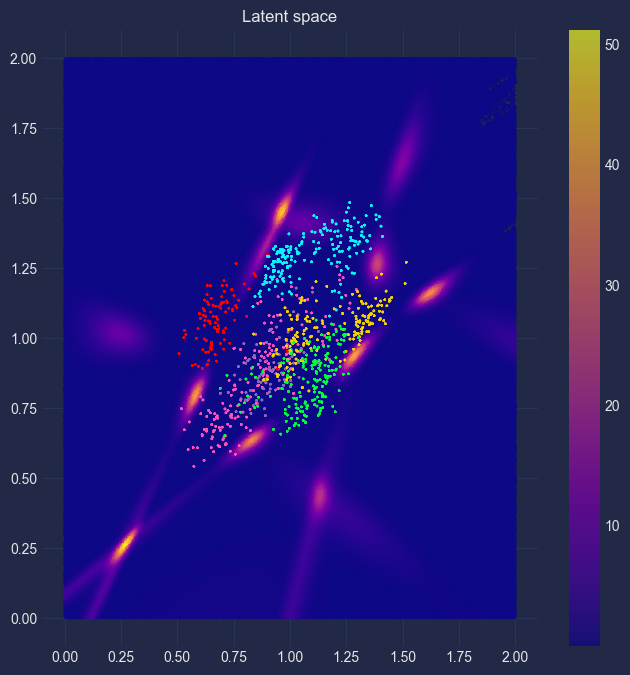

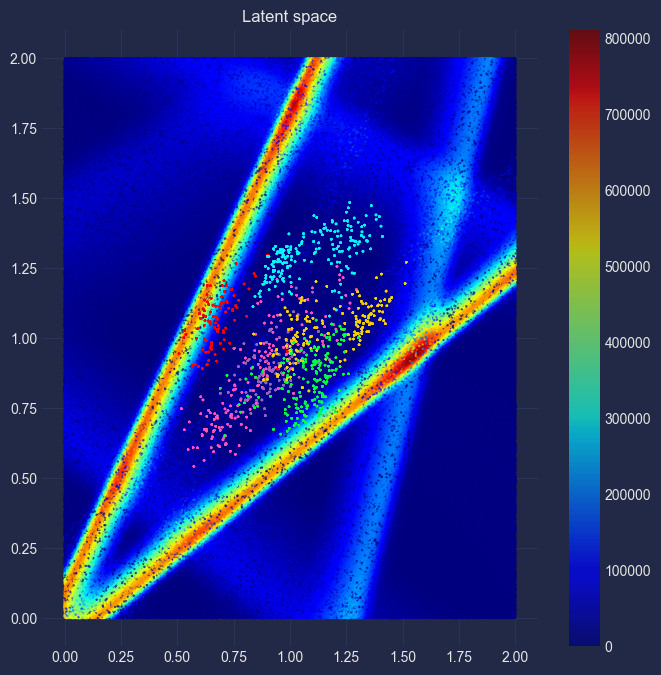

 60%|██████    | 60012/100001 [10:26<4:32:01,  2.45it/s]

60000:(beta)=(    0.6001)


 61%|██████    | 61018/100001 [10:34<05:25, 119.90it/s] 

61000:(beta)=(    0.7481)


 62%|██████▏   | 62021/100001 [10:42<04:21, 145.10it/s]

62000:(beta)=(    0.9705)


 63%|██████▎   | 63027/100001 [10:49<04:30, 136.53it/s]

63000:(beta)=(    0.9486)


 64%|██████▍   | 64017/100001 [10:56<04:13, 141.91it/s]

64000:(beta)=(    0.7138)


 65%|██████▌   | 65023/100001 [11:03<04:06, 141.84it/s]

65000:(beta)=(    0.6025)


 66%|██████▌   | 66029/100001 [11:10<04:00, 141.52it/s]

66000:(beta)=(    0.7742)


 67%|██████▋   | 67016/100001 [11:17<03:59, 137.96it/s]

67000:(beta)=(    0.9829)


 68%|██████▊   | 68021/100001 [11:24<03:40, 145.29it/s]

68000:(beta)=(    0.9295)


 69%|██████▉   | 69026/100001 [11:31<03:36, 143.05it/s]

69000:(beta)=(    0.6906)


 70%|██████▉   | 70000/100001 [11:50<03:31, 141.77it/s]

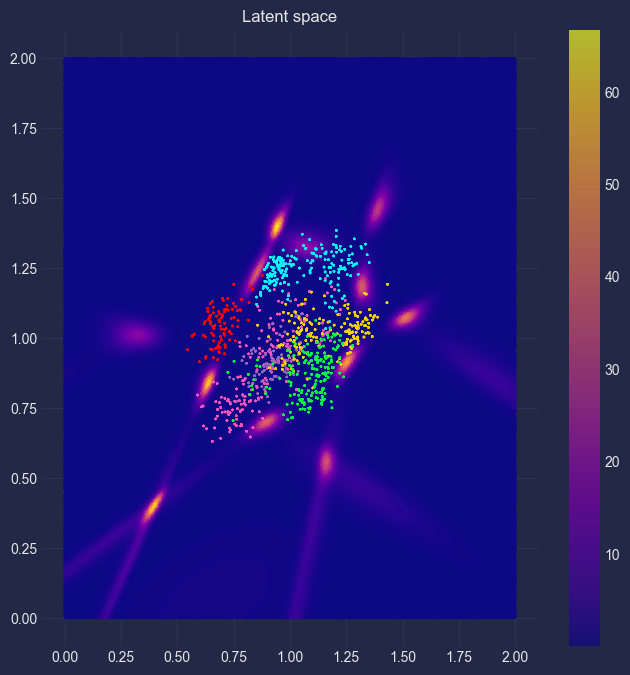

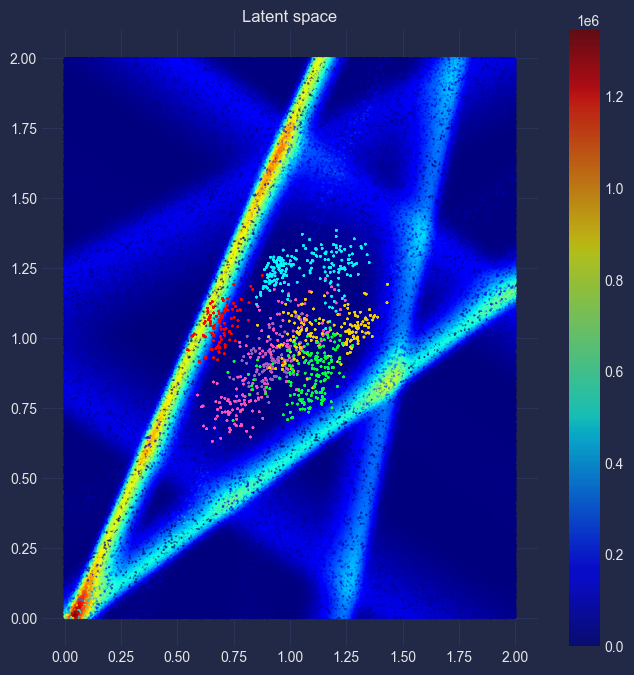

 70%|███████   | 70016/100001 [11:57<2:53:24,  2.88it/s]

70000:(beta)=(    0.6084)


 71%|███████   | 71028/100001 [12:04<03:19, 144.98it/s] 

71000:(beta)=(    0.8007)


 72%|███████▏  | 72016/100001 [12:11<03:19, 140.55it/s]

72000:(beta)=(    0.9920)


 73%|███████▎  | 73021/100001 [12:18<03:05, 145.34it/s]

73000:(beta)=(    0.9082)


 74%|███████▍  | 74029/100001 [12:25<03:02, 142.67it/s]

74000:(beta)=(    0.6694)


 75%|███████▌  | 75017/100001 [12:32<02:57, 140.96it/s]

75000:(beta)=(    0.6177)


 76%|███████▌  | 76026/100001 [12:39<02:45, 145.01it/s]

76000:(beta)=(    0.8272)


 77%|███████▋  | 77017/100001 [12:46<02:43, 140.57it/s]

77000:(beta)=(    0.9977)


 78%|███████▊  | 78025/100001 [12:53<02:32, 144.36it/s]

78000:(beta)=(    0.8849)


 79%|███████▉  | 79019/100001 [13:00<02:27, 142.64it/s]

79000:(beta)=(    0.6505)


 80%|███████▉  | 79994/100001 [13:20<02:24, 138.48it/s]

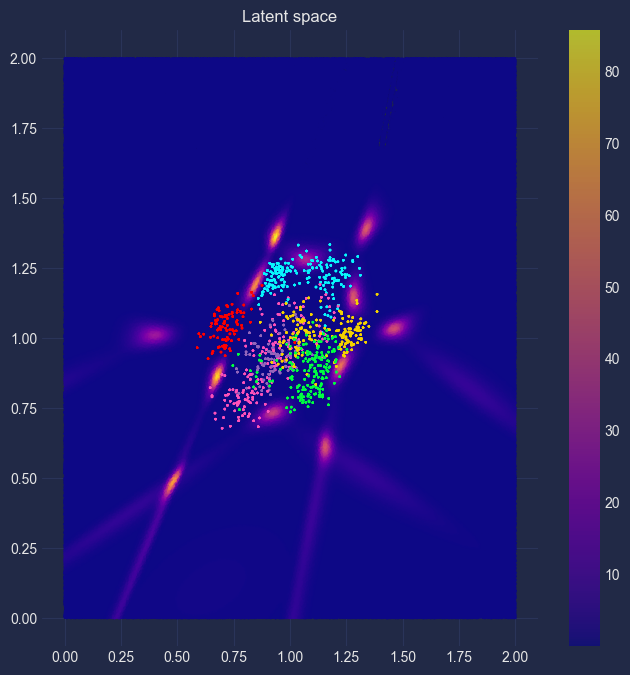

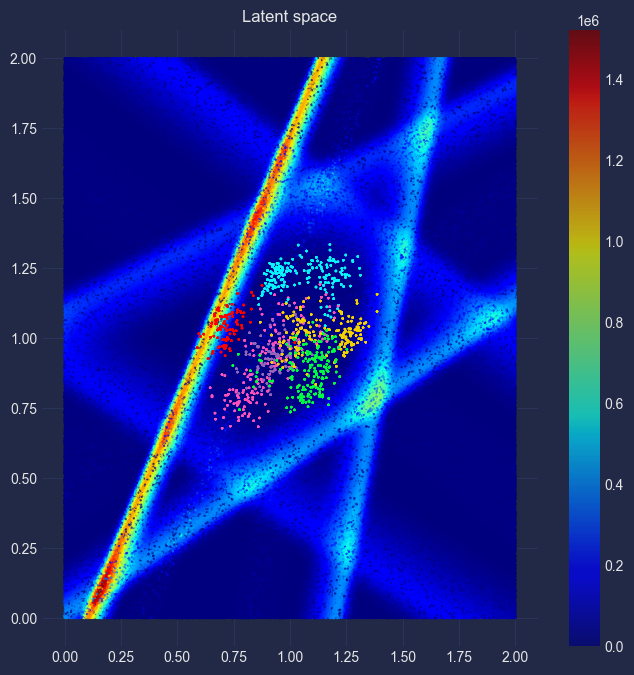

 80%|████████  | 80012/100001 [13:26<1:51:49,  2.98it/s]

80000:(beta)=(    0.6302)


 81%|████████  | 81018/100001 [13:33<02:06, 150.55it/s] 

81000:(beta)=(    0.8533)


 82%|████████▏ | 82021/100001 [13:40<02:00, 148.95it/s]

82000:(beta)=(    1.0000)


 83%|████████▎ | 83015/100001 [13:47<02:01, 140.06it/s]

83000:(beta)=(    0.8602)


 84%|████████▍ | 84024/100001 [13:55<02:00, 132.63it/s]

84000:(beta)=(    0.6342)


 85%|████████▌ | 85017/100001 [14:02<01:42, 145.80it/s]

85000:(beta)=(    0.6458)


 86%|████████▌ | 86019/100001 [14:09<01:40, 138.49it/s]

86000:(beta)=(    0.8783)


 87%|████████▋ | 87026/100001 [14:16<01:32, 140.09it/s]

87000:(beta)=(    0.9987)


 88%|████████▊ | 88023/100001 [14:24<01:34, 127.28it/s]

88000:(beta)=(    0.8344)


 89%|████████▉ | 89023/100001 [14:32<01:33, 117.86it/s]

89000:(beta)=(    0.6208)


 90%|████████▉ | 89992/100001 [14:50<01:13, 135.70it/s]

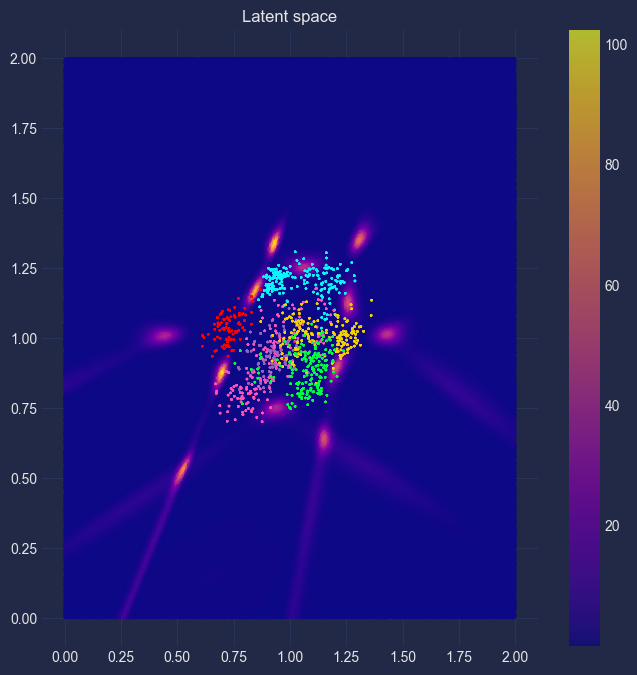

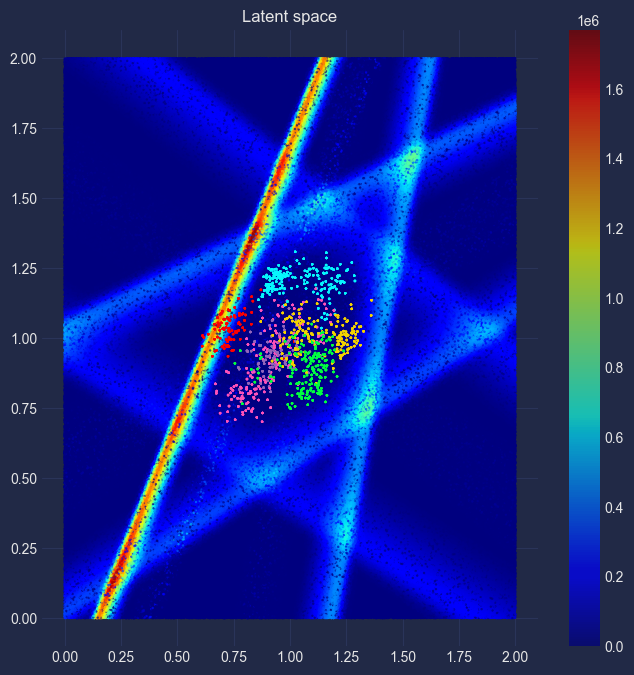

 90%|█████████ | 90016/100001 [15:00<52:23,  3.18it/s]  

90000:(beta)=(    0.6640)


 91%|█████████ | 91013/100001 [15:07<01:10, 126.75it/s]

91000:(beta)=(    0.9021)


 92%|█████████▏| 92016/100001 [15:15<01:01, 129.59it/s]

92000:(beta)=(    0.9939)


 93%|█████████▎| 93014/100001 [15:23<00:55, 126.59it/s]

93000:(beta)=(    0.8079)


 94%|█████████▍| 94014/100001 [15:31<00:47, 125.80it/s]

94000:(beta)=(    0.6106)


 95%|█████████▌| 95025/100001 [15:40<00:42, 118.29it/s]

95000:(beta)=(    0.6846)


 96%|█████████▌| 96016/100001 [15:48<00:31, 127.31it/s]

96000:(beta)=(    0.9240)


 97%|█████████▋| 97020/100001 [15:56<00:28, 105.21it/s]

97000:(beta)=(    0.9857)


 98%|█████████▊| 98023/100001 [16:04<00:15, 125.79it/s]

98000:(beta)=(    0.7814)


 99%|█████████▉| 99014/100001 [16:12<00:07, 125.51it/s]

99000:(beta)=(    0.6038)


100%|█████████▉| 99999/100001 [16:30<00:00, 129.57it/s]

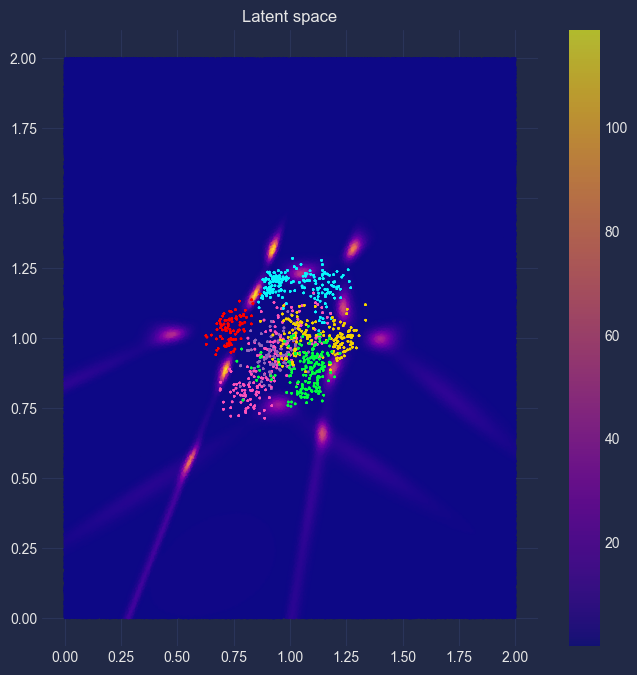

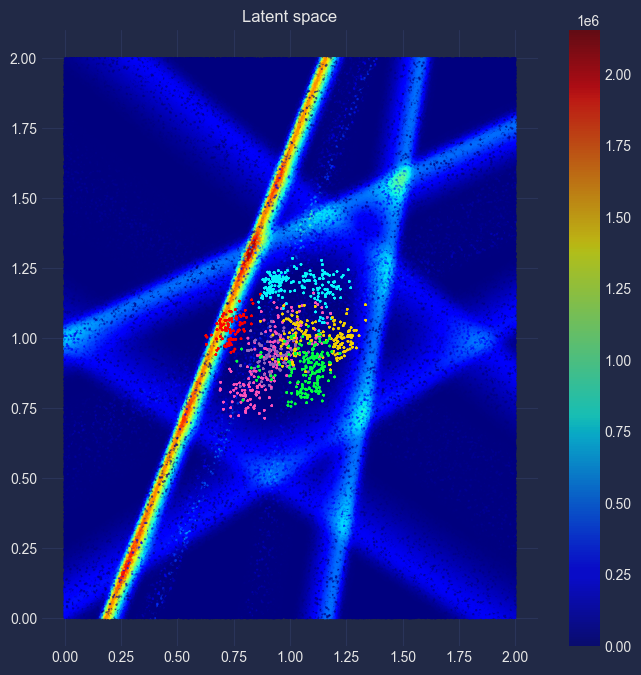

100%|██████████| 100001/100001 [16:39<00:00, 100.04it/s]

100000:(beta)=(    0.7073)


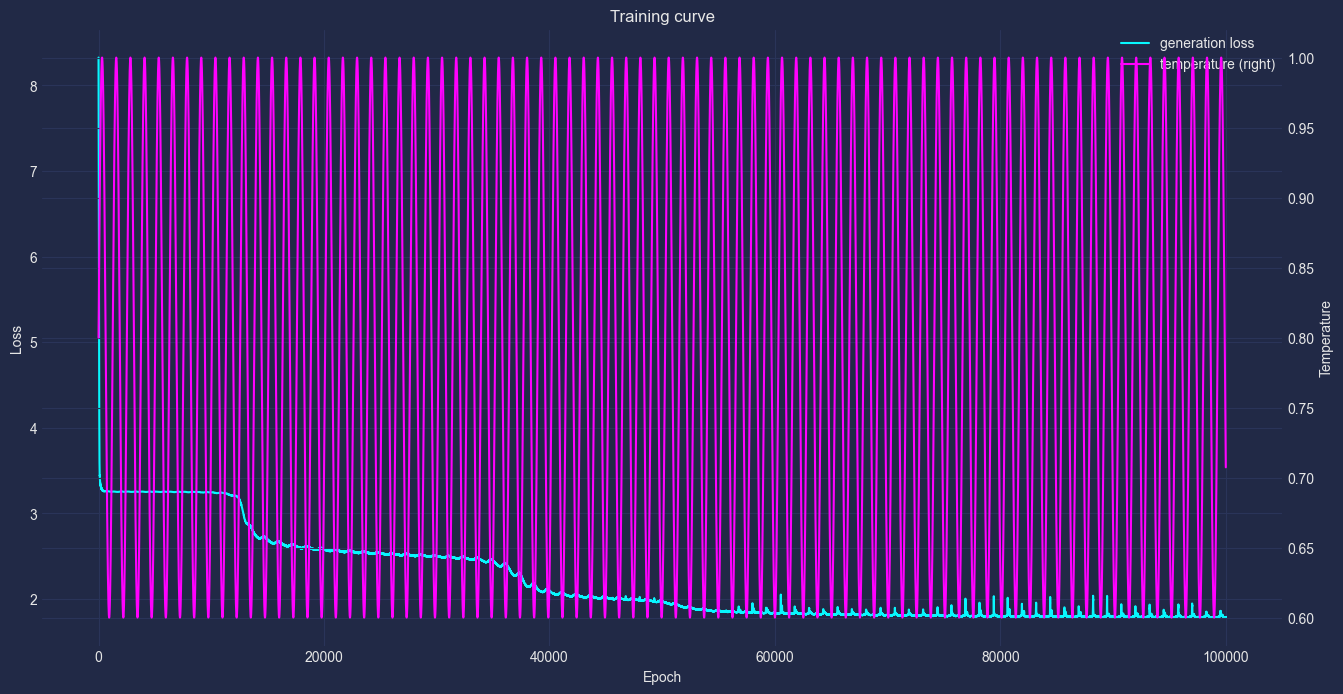

In [4]:
# Optimizer
params = list(encoder.parameters()) + list(decoder.parameters())
#optimizer = optim.Adam(params, lr=5e-5, betas=(0.5, 0.999))
optimizer = optim.SGD(params, lr=1e-3, momentum=0.1)

# Training loop
ac_list = []
gen_loss_list = []
val_list = []
val_gen_loss_list = []
beta_list = []
fifs_list = []

beta_min = 1/5   # must be less than 1/2
cyclical_beta = (1 - beta_min) + beta_min * np.sin(500/n_epoch * np.arange(n_epoch))

for j in tqdm(range(n_epoch)):
    optimizer.zero_grad()
    
    loc, scale = encoder(x)
    prior = Normal(torch.zeros_like(loc), torch.ones_like(scale))
    posterior = Normal(loc, scale)
    z_sample = torch.add(loc, scale.pow_(prior.sample()))
    z_sample.requires_grad_(True)
    
    dec = decoder(z_sample)
    dec.requires_grad_(True)
    log_probs = Bernoulli(probs=dec.pow_(cyclical_beta[j])).log_prob(y)
 
    if j % 10000 == 0:
        n_vis = 10
        enc_test = torch.cat([z_sample for i in range(n_vis)], dim=0).detach().numpy()
        enc_test_label = np.tile(yl_train, (n_vis))
        n_vis = 1000
        z_range = np.random.uniform(0, 2, size=(batch_size*n_vis, latent_dim))
        decoder_params = dict(decoder.named_parameters())
        mfs = np.hstack([compute_magnification_factor(compute_jacobian(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True))).detach().numpy() for i in range(n_vis)])
        fifs = np.hstack([compute_fisher_information_factor(compute_logprobs(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True), cyclical_beta, j)).detach().numpy() for i in range(n_vis)])

        rcParams['figure.figsize'] = 8, 8
        plt.figure()
        plt.scatter(z_range[:, 0], z_range[:, 1],
                    #c=mfs, cmap=plt.cm.Reds,
                    c=mfs, cmap=plt.cm.plasma,
                    edgecolor='none', alpha=0.7, s=3)
        plt.colorbar()
        for i in range(len(np.unique(yl_train))):
            plt.scatter(enc_test[enc_test_label==i, 0], enc_test[enc_test_label==i, 1], 
                        edgecolor='none', alpha=0.7, s=3)
        plt.title('Latent space')
        plt.show()
        
        rcParams['figure.figsize'] = 8, 8
        plt.figure()
        plt.scatter(z_range[:, 0], z_range[:, 1],
                    #c=fifs, cmap=plt.cm.Greens,
                    c=fifs, cmap=plt.cm.jet,
                    edgecolor='none', alpha=0.7, s=3)
        plt.colorbar()
        for i in range(len(np.unique(yl_train))):
            plt.scatter(enc_test[enc_test_label==i][:, 0], enc_test[enc_test_label==i][:, 1],         
                        edgecolor='none', alpha=0.7, s=3)
        plt.title('Latent space')
        plt.show()


    # Loss functions
    kl_divergence = torch.distributions.kl_divergence(posterior, prior).mean()
    recon_likelihood = log_probs.sum(dim=1).mean()
    gen_loss = torch.sub(kl_divergence, recon_likelihood)
    
    gen_loss.backward(retain_graph=True)
    optimizer.step()

    with torch.no_grad():
        correct = (y.argmax(dim=1) == dec.argmax(dim=1)).float()
        accuracy = correct.mean()
        ac_list.append(accuracy.item())
        gen_loss_list.append(gen_loss.item())
        beta_list.append(cyclical_beta[j])
        
        if j % 1000 == 0:
            print("%5d:(beta)=(%10.4f)" % (j, cyclical_beta[j]))

rcParams['figure.figsize'] = 16, 8
fig, ax1 = plt.subplots() 
ax2 = ax1.twinx()
ax1.plot(np.arange(n_epoch), np.asarray(gen_loss_list), label='generation loss')
#ax1.plot(np.arange(n_epoch), np.asarray(val_gen_loss_list), label='validation generation loss')
ax2.plot(np.arange(n_epoch), np.asarray(beta_list), label='temperature (right)', color='magenta')
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=1, borderaxespad=0.1)
plt.title('Training curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Temperature')
plt.show()

In [5]:
loc, scale = encoder(x)
z_sample = torch.add(loc, scale.pow_(prior.sample()))
z_sample.requires_grad_(True)
dec = decoder(z_sample)
dec.requires_grad_(True)
jacobian = compute_jacobian(decoder, decoder_params, z_sample)

n_vis = 10
enc_test = torch.cat([z_sample for i in range(n_vis)], dim=0).detach().numpy()
enc_test_label = np.tile(yl_train, (n_vis))
n_vis = 1000
z_range = np.random.uniform(0, 2, size=(batch_size*n_vis, latent_dim))
decoder_params = dict(decoder.named_parameters())
mfs = np.hstack([compute_magnification_factor(compute_jacobian(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True))).detach().numpy() for i in range(n_vis)])
fifs = np.hstack([compute_fisher_information_factor(compute_logprobs(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True), cyclical_beta, j)).detach().numpy() for i in range(n_vis)])

print(mfs.shape)
print(z_range[:, 0].shape)
print(z_range[:, 1].shape)
print(enc_test.shape)
print(enc_test_label.shape)

(898000,)
(898000,)
(898000,)
(8980, 2)
(8980,)


In [6]:
print(enc_test)
print(enc_test_label)

[[1.1428677  1.2299578 ]
 [1.047522   1.0590073 ]
 [1.1472313  0.9851121 ]
 ...
 [0.93266314 0.96560836]
 [1.1440533  0.77664   ]
 [1.0974774  0.7814307 ]]
[0 8 9 ... 1 3 3]


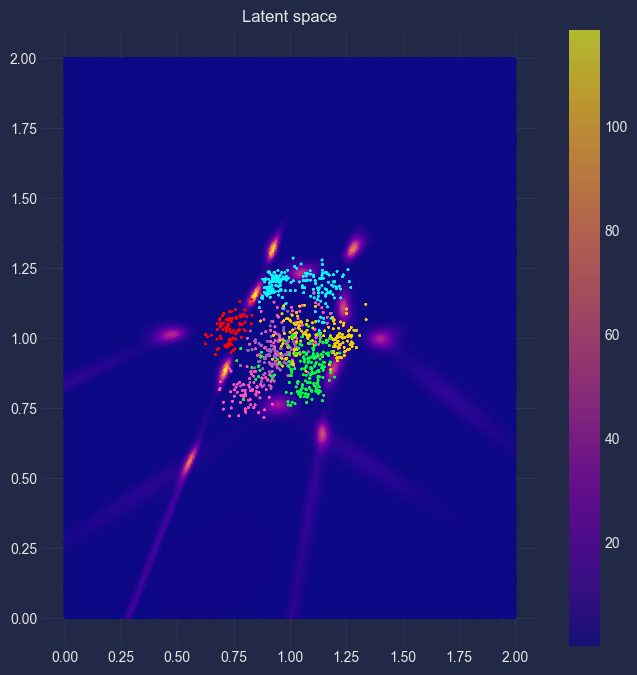

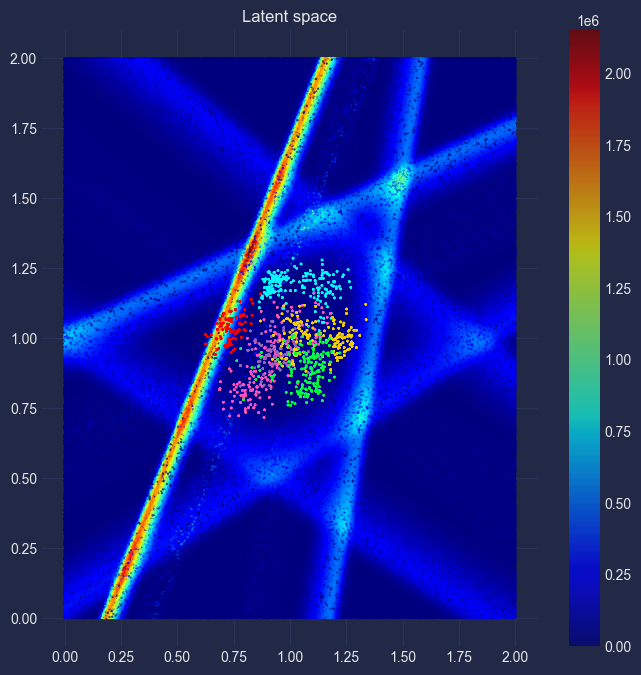

In [7]:
rcParams['figure.figsize'] = 8, 8
plt.figure()
plt.scatter(z_range[:, 0], z_range[:, 1],
            c=mfs, cmap=plt.cm.plasma,
            edgecolor='none', alpha=0.7, s=3)
plt.colorbar()
for i in range(len(np.unique(yl_train))):
    plt.scatter(enc_test[enc_test_label==i, 0], enc_test[enc_test_label==i, 1], 
                edgecolor='none', alpha=0.7, s=3)
plt.title('Latent space')
plt.show()

rcParams['figure.figsize'] = 8, 8
plt.figure()
plt.scatter(z_range[:, 0], z_range[:, 1],
            c=fifs, cmap=plt.cm.jet,
            edgecolor='none', alpha=0.7, s=3)
plt.colorbar()
for i in range(len(np.unique(yl_train))):
    plt.scatter(enc_test[enc_test_label==i][:, 0], enc_test[enc_test_label==i][:, 1],         
                edgecolor='none', alpha=0.7, s=3)
plt.title('Latent space')
plt.show()

(4490, 4490)


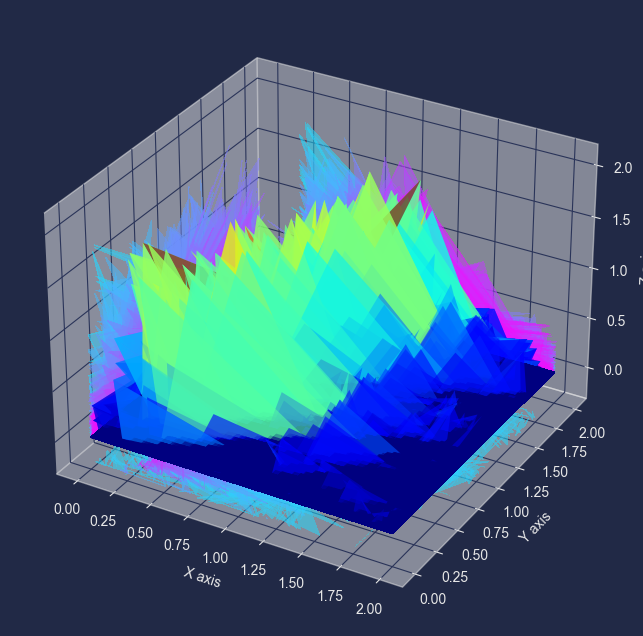

In [8]:
n_vis = 5
z_range = np.random.uniform(0, 2, size=(batch_size*n_vis, latent_dim))
decoder_params = dict(decoder.named_parameters())
#Z_list = [compute_magnification_factor(compute_jacobian(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True))).detach().numpy() for i in range(n_vis)]
Z_list = [compute_fisher_information_factor(compute_logprobs(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True), cyclical_beta, j)).detach().numpy() for i in range(n_vis)]
Z = np.zeros((batch_size*n_vis, batch_size*n_vis))
for i in range(n_vis):
    Z[i*batch_size:(i+1)*batch_size, i*batch_size:(i+1)*batch_size] = np.diag(Z_list[i])
print(Z.shape)

x_lim = 2
y_lim = 2
z_lim = np.amax(fifs)

# Create a meshgrid of x and y values
X, Y = np.meshgrid(z_range[:, 0], z_range[:, 1])

# Create the 3D plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, Z, cmap='jet', rstride=1, cstride=1, alpha=0.6)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-1/8*z_lim, alpha=0.3)
cset = ax.contourf(X, Y, Z, zdir='x', offset=0, alpha=0.3)
cset = ax.contourf(X, Y, Z, zdir='y', offset=2, alpha=0.3)

# Set plot labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

ax.set_zlim(-1/8*z_lim, z_lim)

# Show the plot
plt.show()